In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [6]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [7]:
df['is_referral'].value_counts()

1    32144
0    31856
Name: is_referral, dtype: int64

In [8]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [9]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [10]:
df = df.rename(columns={'offer': 'treatment', 'conversion': 'target'})

In [11]:
df.treatment = df.treatment.map({'No Offer': 0, 'Discount': 1, 'Buy One Get One': 1})

In [12]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### feature engineering

In [13]:
df['recency'].value_counts()

1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: recency, dtype: int64

In [14]:
df['recency_less3months'] = (df['recency'] <= 3).astype('int')
df['recency_less6months'] = ((df['recency'] > 3) & (df['recency'] <= 6)).astype('int')
df['recency_less6months'] = ((df['recency'] > 6) & (df['recency'] <= 9)).astype('int')
df['recency_less6months'] = ((df['recency'] > 9) & (df['recency'] <= 12)).astype('int')

In [15]:
df['history_less100'] = (df['history'] <= 100).astype('int')
df['history_less200'] = ((df['history'] > 100) & (df['history'] <= 200)).astype('int')
df['history_less300'] = ((df['history'] > 200) & (df['history'] <= 300)).astype('int')
df['history_less400'] = ((df['history'] > 300) & (df['history'] <= 400)).astype('int')
df['history_more400'] = (df['history'] > 400 ).astype('int')

In [16]:
indices_train = df.index
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123)

In [17]:
X_train = df.loc[indices_learn, : ].drop(['target'], axis=1)
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(['target'], axis=1)
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

## S-Learner

In [18]:
# !pip install scikit-uplift==0.2.0

In [19]:
# !pip install catboost

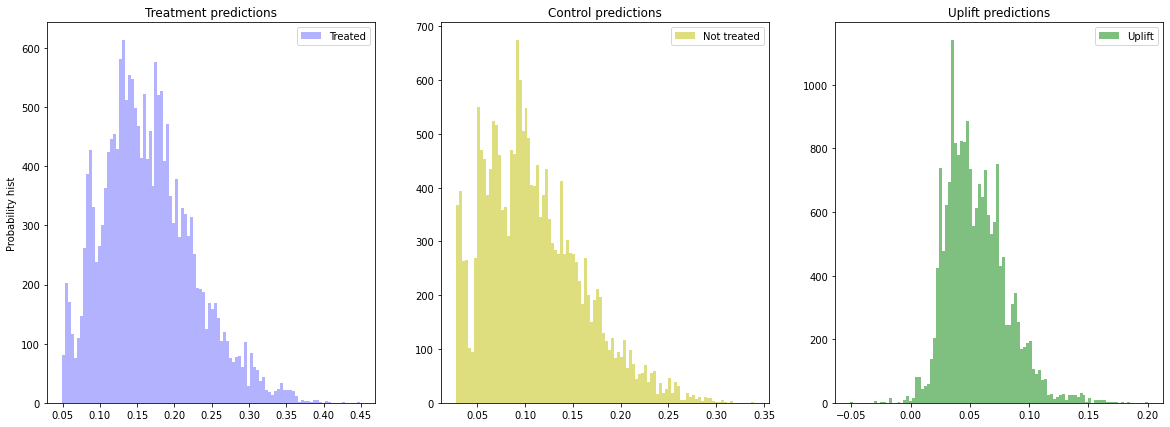

In [20]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## ClassTransform

In [21]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


## Две независимые модели

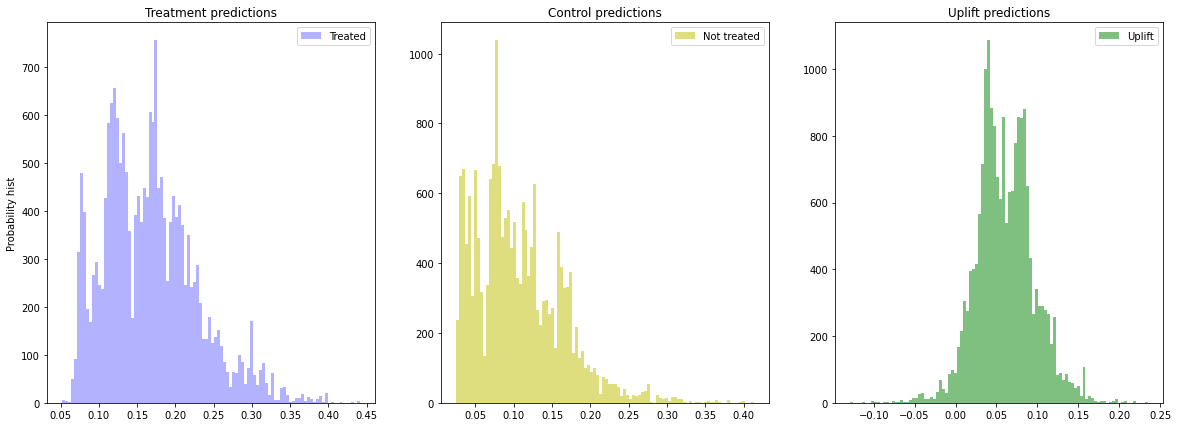

In [22]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Results

In [23]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.255693,0.209472
2,TwoModels,0.077515,0.075078
0,SoloModel,0.073616,0.077816


In [ ]:
# without_Feature_engineering = pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)
# without_Feature_engineering

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.245531,0.209864
0,SoloModel,0.089254,0.078994
2,TwoModels,0.078306,0.068439


С новыми фичами, у нас улучшился uplift@10% на ClassTransformation, но упал на Solo и Two Models

## Дерево решений

In [24]:
# !pip install causalml

In [25]:
X_train_tree = pd.get_dummies(X_train[cat_features])

In [26]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train[cat_features])], 1)

features = [col for col in X_train_tree]

In [27]:
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,treatment,recency_less3months,recency_less6months,history_less100,history_less200,history_less300,history_less400,history_more400,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
53181,8,121.56,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
42635,9,617.62,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0
6296,5,185.62,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
41722,1,359.03,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1
32660,10,139.68,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61404,1,172.98,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1
17730,9,95.41,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
28030,1,547.69,1,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0
15725,5,341.39,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0


In [28]:
y_train

53181    0
42635    0
6296     1
41722    0
32660    0
        ..
61404    0
17730    0
28030    1
15725    1
52734    0
Name: target, Length: 44800, dtype: int64

In [29]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPU times: user 715 ms, sys: 189 ms, total: 904 ms
Wall time: 793 ms


In [30]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

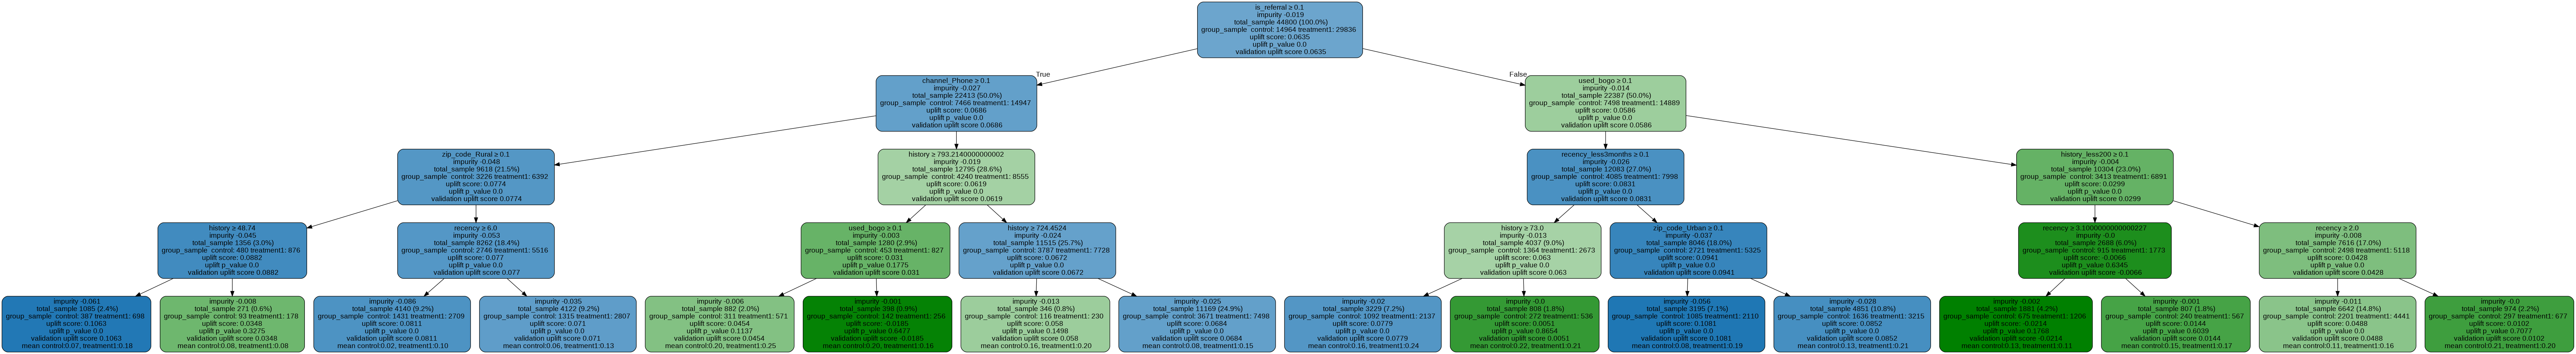

In [31]:
uplift_random_forest = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_random_forest.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

uplift_tree = uplift_random_forest.uplift_forest[0]

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,features)
Image(graph.create_png())

(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 


1) сделать прогноз и получить uplift для тестовой выборки

2) отсортировать тестовую выборку по uplift по убыванию 

3) разбить на децили (pandas qcut вам в помощь) 

4) для каждого дециля посчитать среднюю conversion

### Роман, в данному пункте я совсем не уверен

In [32]:
quantiles_sm = pd.DataFrame({'conversion': y_val, 'uplift': uplift_sm})

In [33]:
quantiles_sm.sort_values('uplift', ascending=False)

,conversion,uplift
13263,1,0.200507
9638,0,0.200507
25861,0,0.185156
235,0,0.185156
13814,1,0.179068
...,...,...
11790,0,-0.030262
42205,0,-0.051333
6164,1,-0.051333
13434,0,-0.051333


In [34]:
quantiles_sm['quantile'] = pd.qcut(quantiles_sm['uplift'], q=10)

In [35]:
quantiles_sm.groupby('quantile').mean()

,conversion,uplift
quantile,,
"(-0.0523, 0.0268]",0.112324,0.019902
"(0.0268, 0.0347]",0.119729,0.031131
"(0.0347, 0.0397]",0.132085,0.036943
"(0.0397, 0.0458]",0.134266,0.042748
"(0.0458, 0.0516]",0.129134,0.048538
"(0.0516, 0.0593]",0.155810,0.055619
"(0.0593, 0.0666]",0.157812,0.062919
"(0.0666, 0.0745]",0.160417,0.070854
"(0.0745, 0.0884]",0.161979,0.080938
